# 亜臨界ホップ分岐の標準形

\begin{equation}
\begin{aligned}
    \dot{x}_0 = \lambda x_0 - \omega x_1 + x_0 \left[ c_1 (x_0^2 + x_1^2) - (x_0^2 + x_1^2)^2 \right],\\
    \dot{x}_1 = \omega x_0 + \lambda x_1 + x_1 \left[ c_1 (x_0^2 + x_1^2) - (x_0^2 + x_1^2)^2 \right],\\
\end{aligned}
\end{equation}

In [1]:
import numpy as np
import pathfollowing as pf
from scipy.integrate import ode, solve_ivp
from scipy.linalg import solve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set('poster', 'whitegrid', 'dark', rc={"lines.linewidth": 2, 'grid.linestyle': '-'})

ベクトル場とその微分

In [2]:
c_lyap = 0.25
def f(x, a):
    A = np.array([[a[0], -1.0],[1.0, a[0]]])
    r = x@x
    return A @ x + r*(c_lyap - r)*x

def fx(x, a):
    r = x @ x
    a00 = a[0] + r*(c_lyap - r) + 2*(c_lyap - 2*r)*x[0]**2
    a01 = -1.0 + 2*x[0]*x[1]*(c_lyap - 2*r)
    a10 = 1.0 + 2*x[0]*x[1]*(c_lyap - 2*r)
    a11 = a[0] + r*(c_lyap-r)+2*(c_lyap-2*r)*x[1]**2
    return np.array([[a00, a01],[a10, a11]])

def fa(x, a):
    return np.array([x[0], x[1]])

一段射撃法の定式化

In [3]:
def func(x, a):
    T = x[-1]
    def f2(t, y):
        return T * f(y, a)
    r = ode(f2).set_integrator('dop853')
    y0 = np.copy(x[:-1])
    h = 1.0
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1 = np.zeros(len(x))
    x1[:-1] = y1 - y0
    x1[-1] = y0[0]
    return x1

def dfdx(x, a):
    def df2(t, y, n):
        z = np.zeros((n+1)*(n+2))
        z[:n] = y[n] * f(y[:n], a)
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = y[n] * fx(y[:n], a)
        J[:n, n] = f(y[:n], a)
        for m in range(n+1):
            z[(n+1)*(m+1):(n+1)*(m+2)] = J @ y[(n+1)*(m+1):(n+1)*(m+2)]
        return z
    r = ode(df2).set_integrator('dop853')
    n = len(x)-1
    y0 = np.zeros((n+1)*(n+2))
    I = np.identity(n+1)
    y0[:n+1] = np.copy(x)
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    h = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    A = -np.identity(n+1)
    for m in range(n+1):
        A[:-1,m] += y1[(n+1)*(m+1):(n+1)*(m+2)-1]
    A[-1,:] = 0.0
    A[-1,0] = 1.0 
    return A

def dfda(x, a):
    T = x[-1]
    def df2(t, y, n):
        z = np.zeros(2*(n+1))
        z[:n] = T * f(y[:n], np.array([y[n]]))
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = fx(y[:n], np.array([y[n]]))
        J[:n, n] = fa(y[:n], np.array([y[n]]))
        z[n+1:] = T * J @ y[n+1:]
        return z
    r = ode(df2).set_integrator('dop853')
    n = len(x)-1
    y0 = np.zeros(2*(n+1))
    y0[:n] = np.copy(x[:-1])
    y0[n] = a[0]
    y0[-1] = 1.0
    h = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    y1[-1] = 0.0
    return y1[n+1:]

一段射撃法のニュートン法

In [4]:
x = np.array([0.0, 0.5, 2*np.pi])
a = np.array([0.00])
y = np.copy(x)
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(y, np.linalg.norm(b))

[0.         0.50000006 6.28318561] 1.534154170863662e-07
[0.         0.50000006 6.28318561] 4.9608493090846714e-14
[0.         0.50000006 6.28318561] 1.047382306668854e-15
[0.         0.50000006 6.28318561] 2.159233940399377e-15
[0.         0.50000006 6.28318561] 1.790180836524724e-15
[0.         0.50000006 6.28318561] 3.6691989157368576e-15
[0.         0.50000006 6.28318561] 2.5823128856601336e-15
[0.         0.50000006 6.28318561] 4.742874840267547e-16
[0.         0.50000006 6.28318561] 5.900916318210353e-16
[0.         0.50000006 6.28318561] 3.0967063759893227e-15


一段射撃法の追跡

In [5]:
x=np.array([0.0, 0.5, 2*np.pi])
a=np.array([0.0])
bd,bp,lp=pf.pathfollow(x, a, func, dfdx, dfda,nmax=20, h=0.05, epsr=1.0e-10, epsb=1.0e-10, quiet=False)

# TY a x
R 0.015023155570483651 0.0 -0.4014886326913046 -1.1210151741032572
R 0.035917260293237226 0.0 -0.5137134389482804 -1.0830209867548288
R 0.06238882678998029 0.0 -0.598635550276071 -1.0336654249654065
R 0.09366115556610179 0.0 -0.6596456895451372 -0.9906320993827148
R 0.12878337264553655 0.0 -0.7049271175618399 -0.9606197790481326
R 0.16687167400969033 0.0 -0.7411210689365288 -0.9433512479878107
R 0.20720964186011206 0.0 -0.7720442328849861 -0.9359801983313732
R 0.249254084532369 0.0 -0.7995859087257013 -0.9355073217026986
R 0.2926045087542456 0.0 -0.8246703700354263 -0.939585814511053
R 0.3369675354791696 0.0 -0.8477989761336331 -0.9465799839662211
R 0.3821271995562121 0.0 -0.8692906175761658 -0.9554041805435147
R 0.4279228184124911 0.0 -0.8893765913715667 -0.9653493846126342
R 0.47423331226694254 0.0 -0.9082387879660252 -0.9759536058460752
R 0.5209660539735923 0.0 -0.9260254818232135 -0.9869139548929227
R 0.5680492881279677 0.0 -0.9428602121660424 -0.9980308609630433
R 0.61542

一段射撃法では不安定なリミットサイクルを上手く追跡できない

In [ ]:
bd2,bp2,lp2=pf.pathfollow(x, a, func, dfdx, dfda,nmax=160, h=-0.01, epsr=1.0e-10, epsb=1.0e-10, quiet=True)

2段射撃法の定式化

In [6]:
Npts = 2
def func(x, a):
    T = x[-1]
    def f2(t, y):
        return T * f(y, a)
    r = ode(f2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    x1 = np.zeros(len(x))
    y0 = np.copy(x[:n])
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1[:n] = y1 - x[n:2*n]

    y0 = np.copy(x[n:2*n])
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1[n:2*n] = y1 - x[:n]

    x1[-1] = x[0]
    return x1

def dfdx(x, a):
    def df2(t, y, n):
        z = np.zeros((n+1)*(n+2))
        z[:n] = y[n] * f(y[:n], a)
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = y[n] * fx(y[:n], a)
        J[:n, n] = f(y[:n], a)
        for m in range(n+1):
            z[(n+1)*(m+1):(n+1)*(m+2)] = J @ y[(n+1)*(m+1):(n+1)*(m+2)]
        return z
    r = ode(df2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x)-1) // Npts
    h = 1.0 / Npts
    A = np.zeros((len(x), len(x)))

    y0 = np.zeros((n+1)*(n+2))
    I = np.identity(n+1)
    y0[:n] = x[:n]
    y0[n] = x[-1]
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    for m in range(n):
        A[:n,m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
    A[:n, n:2*n] = -np.identity(n)
    A[:n, -1] = y1[-(n+1):-1]

    y0 = np.zeros((n+1)*(n+2))
    y0[:n] = x[n:2*n]
    y0[n] = x[-1]
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    for m in range(n):
        A[n:2*n,n+m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
    A[n:2*n, :n] = -np.identity(n)
    A[n:2*n, -1] = y1[-(n+1):-1]
    A[-1,0] = 1.0
    return A

def dfda(x, a):
    T = x[-1]
    def df2(t, y, n):
        z = np.zeros(2*(n+1))
        z[:n] = T * f(y[:n], np.array([y[n]]))
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = fx(y[:n], np.array([y[n]]))
        J[:n, n] = fa(y[:n], np.array([y[n]]))
        z[n+1:] = T * J @ y[n+1:]
        return z
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    r = ode(df2).set_integrator('dop853', atol=1e-14, rtol=1e-14)
    b = np.zeros(len(x))
    y0 = np.zeros(2*(n+1))
    y0[:n] = np.copy(x[:n])
    y0[n] = a[0]
    y0[-1] = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    b[:n] = y1[n+1:2*n+1]

    y0[:n] = np.copy(x[n:2*n])
    y0[n] = a[0]
    y0[-1] = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    b[n:2*n] = y1[n+1:2*n+1]

    return b

２段射撃法のニュートン法

In [7]:
x = np.array([0.0, 0.5, 0.0, -0.5, 2*np.pi])
a = np.array([0.0])
y = np.copy(x)
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(y[:2], y[-1], np.linalg.norm(b))

[1.03152808e-30 5.00000000e-01] 6.283185307179601 5.9170423507905885e-15
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 3.4577177419348924e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.422896290682169e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.42289629068217e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.4228962906821706e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.422896290682171e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.422896290682171e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.422896290682171e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.422896290682171e-16
[-3.85185989e-33  5.00000000e-01] 6.283185307179601 1.422896290682171e-16


２段射撃法の追跡

In [8]:
x=np.array([0.0, 0.5, 0.0, -0.5, 2*np.pi])
a=np.array([0.0])
bd,bp,lp=pf.pathfollow(x, a, func, dfdx, dfda,nmax=20, h=0.05, epsr=1.0e-10, epsb=1.0e-10, quiet=False)

# TY a x
R 0.010238862505482822 -5.403755707824863e-32 -0.3662316500243911 -1.5498606621213413
R 0.023739873764932994 -4.733750501935393e-33 -0.4553158497308608 -1.4976143607705639
R 0.04071774492605943 -4.733750501935393e-33 -0.5326683322583992 -1.4215795060654648
R 0.06124544544111728 -4.733750501935393e-33 -0.595783057204346 -1.33786000086712
R 0.08524514750751452 -4.733750501935393e-33 -0.645843059581797 -1.258955671257655
R 0.11250697657464735 -4.733750501935393e-33 -0.6859340014747413 -1.1920208867688635
R 0.14272871566530332 -4.733750501935393e-33 -0.719272411828372 -1.1394278395780593
R 0.17556223958176542 -4.733750501935393e-33 -0.7482786043200086 -1.1004645408132008
R 0.2106536541412975 -4.733750501935393e-33 -0.7744508738274067 -1.0730099622800326
R 0.24767068404422057 -4.733750501935393e-33 -0.7986132498030031 -1.0546474955082767
R 0.28631720026645063 -4.733750501935393e-33 -0.8212010575834192 -1.043208091386597
R 0.3263380778023389 -4.733750501935393e-33 -0.842457260544173

In [9]:
x=np.array([0.0, 0.5, 0.0, -0.5, 2*np.pi])
a=np.array([0.0])
bd2,bp2,lp2=pf.pathfollow(x, a, func, dfdx, dfda,nmax=70, h=-0.01, epsr=1.0e-10, epsb=1.0e-10, quiet=False)

# TY a x
R -0.0016825386140757964 7.02246187503377e-32 -0.253373901911225 -1.5594923177185995
R -0.003250526669919375 -9.500955706734343e-33 -0.23495225480671061 -1.554225015837006
R -0.004707045164395174 -4.1717537362564895e-32 -0.21684026359514308 -1.5468666346052207
R -0.006055255185025018 -4.745611209927768e-33 -0.19910931589742567 -1.5374020664495056
R -0.007298384840448311 6.937419267494025e-33 -0.18182701631679232 -1.5258313322500723
R -0.008439716743882195 2.1403554471442047e-32 -0.16505638049320132 -1.512169384074778
R -0.009482576120891142 -3.182652306984614e-32 -0.14885513870366288 -1.4964457011495438
R -0.010430319595285854 -1.9254836635551235e-32 -0.1332751587127739 -1.4787036956990314
R -0.011286324690703826 -2.3660363989649884e-33 -0.11836199364344027 -1.4589999486902951
R -0.012053980070587788 -8.15659325687763e-32 -0.10415455686249707 -1.4374032980901197
R -0.012736676526062455 1.2532475427875193e-31 -0.09068492238716055 -1.413993803993903
R -0.01333779870965182 -1.690

In [10]:
bd_r = np.array([bd[m]['a'][0] for m in range(len(bd))])
bd_x = np.array([bd[m]['x'][1] for m in range(len(bd))])
bd2_r = np.array([bd2[m]['a'][0] for m in range(len(bd2))])
bd2_x = np.array([bd2[m]['x'][1] for m in range(len(bd2))])

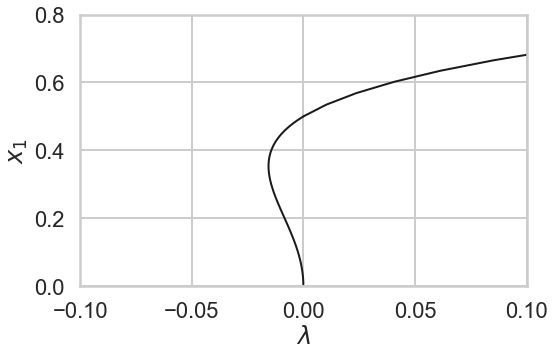

In [11]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-0.1,0.1)
ax.set_ylim(0, 0.8)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("$x_1$")
ax.plot(bd_r, bd_x, '-k')
ax.plot(bd2_r, bd2_x, '-k')
# plt.savefig("bd_hopf_sub.pdf", bbox_inches='tight')

Ｎ段射撃法の定式化

In [12]:
Npts = 4
def func(x, a):
    T = x[-1]
    def f2(t, y):
        return T * f(y, a)
    r = ode(f2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    x1 = np.zeros(len(x))

    for k in range(Npts-1):
        y0 = np.copy(x[k*n:(k+1)*n])
        r.set_initial_value(y0, 0.0)
        y1 = r.integrate(r.t+h)
        x1[k*n:(k+1)*n] = y1 - x[(k+1)*n:(k+2)*n]

    y0 = np.copy(x[-(n+1):-1])
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1[-(n+1):-1] = y1 - x[:n]

    x1[-1] = x[0]
    return x1

def dfdx(x, a):
    def df2(t, y, n):
        z = np.zeros((n+1)*(n+2))
        z[:n] = y[n] * f(y[:n], a)
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = y[n] * fx(y[:n], a)
        J[:n, n] = f(y[:n], a)
        for m in range(n+1):
            z[(n+1)*(m+1):(n+1)*(m+2)] = J @ y[(n+1)*(m+1):(n+1)*(m+2)]
        return z
    r = ode(df2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x)-1) // Npts
    h = 1.0 / Npts
    A = np.zeros((len(x), len(x)))
    I = np.identity(n+1)

    for k in range(Npts-1):
        y0 = np.zeros((n+1)*(n+2))
        y0[:n] = x[k*n:(k+1)*n]
        y0[n] = x[-1]
        for m in range(n+1):
            y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
        r.set_initial_value(y0, 0.0).set_f_params(n)
        y1 = r.integrate(r.t+h)
        for m in range(n):
            A[k*n:(k+1)*n,k*n+m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
        A[k*n:(k+1)*n, (k+1)*n:(k+2)*n] = -np.identity(n)
        A[k*n:(k+1)*n, -1] = y1[-(n+1):-1]

    y0 = np.zeros((n+1)*(n+2))
    y0[:n] = x[-(n+1):-1]
    y0[n] = x[-1]
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    for m in range(n):
        A[-(n+1):-1,-(n+1)+m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
    A[-(n+1):-1, :n] = -np.identity(n)
    A[-(n+1):-1, -1] = y1[-(n+1):-1]
    A[-1,0] = 1.0
    return A

def dfda(x, a):
    T = x[-1]
    def df2(t, y, n):
        z = np.zeros(2*(n+1))
        z[:n] = T * f(y[:n], np.array([y[n]]))
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = fx(y[:n], np.array([y[n]]))
        J[:n, n] = fa(y[:n], np.array([y[n]]))
        z[n+1:] = T * J @ y[n+1:]
        return z
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    r = ode(df2).set_integrator('dop853', atol=1e-14, rtol=1e-14)
    b = np.zeros(len(x))

    for k in range(Npts-1):
        y0 = np.zeros(2*(n+1))
        y0[:n] = np.copy(x[k*n:(k+1)*n])
        y0[n] = a[0]
        y0[-1] = 1.0
        r.set_initial_value(y0, 0.0).set_f_params(n)
        y1 = r.integrate(r.t+h)
        b[k*n:(k+1)*n] = y1[n+1:2*n+1]

    y0[:n] = np.copy(x[-(n+1):-1])
    y0[n] = a[0]
    y0[-1] = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    b[-(n+1):-1] = y1[n+1:2*n+1]

    return b

In [13]:
x = np.array([0.0, 0.5, -0.5, 0.0, 0.0, -0.5, 0.5, 0.0, 2*np.pi])
a = np.array([0.0])
y = np.copy(x)
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(y[:2], y[-1], np.linalg.norm(b))

[7.00143703e-31 5.00000000e-01] 6.283185307179599 3.660606886031751e-15
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.5511151231256336e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.551115123125776e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.5511151231257796e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.5511151231257815e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.551115123125783e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.551115123125783e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.551115123125783e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.5511151231257815e-17
[6.4594719e-34 5.0000000e-01] 6.283185307179599 5.5511151231257815e-17


In [15]:
x = np.array([0.0, 0.5, -0.5, 0.0, 0.0, -0.5, 0.5, 0.0, 2*np.pi])
a=np.array([0.0])
bd2,bp2,lp2=pf.pathfollow(x, a, func, dfdx, dfda,nmax=70, h=-0.01, epsr=1.0e-10, epsb=1.0e-10, quiet=False)

# TY a x
R -0.001210268696060905 7.198167504054491e-32 -0.2587215678218521 -2.1918394978718214
R -0.0023612070190184293 -7.21711024583157e-32 -0.24552966875223967 -2.188928139255222
R -0.00345408333781922 -8.814414118241897e-33 -0.23248150764202807 -2.184435318491585
R -0.004490171124609288 -1.8836903516904824e-31 -0.21960270477940474 -2.1783524761134347
R -0.005470747503757936 7.587450033747564e-33 -0.20691807158734546 -2.1706766196547833
R -0.006397091866208182 1.218589692112546e-32 -0.19445146066600277 -2.161410283164076
R -0.007270484549517834 5.966658182570574e-32 -0.18222562760231445 -2.1505614493633103
R -0.008092205583572721 2.527208452493161e-33 -0.17026210563868416 -2.138143436274803
R -0.008863533501607799 3.4767697796386317e-31 -0.1585810940735847 -2.12417475045875
R -0.009585744215846688 -6.254627325329278e-32 -0.14720136104662054 -2.1086789092818727
R -0.010260109956806077 6.568973293615825e-32 -0.13614016114321376 -2.091684234867552
R -0.010887898275042022 -7.37911432883